StepFun 图片理解最佳实践（Jupyter 笔记）

本笔记基于 StepFun 官方文档“图片理解最佳实践”，整理了常用用法与示例代码，方便快速上手与复用。

参考文档：
- [图片理解最佳实践](https://platform.stepfun.com/docs/guide/image_chat)

内容涵盖：
- 简单图片理解（传入单张图片）
- 多轮对话与多图描述策略
- `detail` 参数的使用（low/high）
- 图片优化（resize、压缩）以降低首字延时
- 透明 PNG 适配（RGBA 转 RGB 白底）
- 以 Base64 方式传图
- 常见问题与限制说明

> 目前推荐使用 step-1o-turbo-vision 模型。该模型拥有最强的视频理解能力，推荐默认开启 detail 模式。


# 一、实现图片理解

In [ ]:
# 环境依赖与客户端初始化
# - 需要 openai>=1.30.0 （API 兼容 StepFun）
# - 需要设置环境变量 API_KEY

import os
from openai import OpenAI

STEPFUN_API_KEY = os.environ.get("STEPFUN_API_KEY")
if not STEPFUN_API_KEY:
    raise RuntimeError("未检测到环境变量 API_KEY，请在运行前设置，例如：export API_KEY='sk-xxx'")

# 指向 StepFun 平台
client = OpenAI(api_key=STEPFUN_API_KEY, base_url="https://api.stepfun.com/v1")

DEFAULT_VISION_MODEL = "step-1o-turbo-vision"
system_prompt = "你是由阶跃星辰提供的AI聊天助手，你除了擅长中文，英文，以及多种其他语言的对话以外，还能够根据用户提供的图片，对内容进行精准的内容文本描述。在保证用户数据安全的前提下，你能对用户的问题和请求，作出快速和精准的回答。同时，你的回答和建议应该拒绝黄赌毒，暴力恐怖主义的内容"




###  1.1简单图片理解

In [ ]:
# 简单图片理解示例
# 传入一张图片并请求描述
# 阶跃星辰支持在 image_url 类型中使用 URL 或 Base64 格式的内容，为了保证更好的性能，推荐使用 URL 来完成图片参数的传递

TEST_IMAGE_URL = "https://q0.itc.cn/q_70/images01/20240612/8e0b7aecb4984be19faaa78f4ecd7c92.jpeg"
completion = client.chat.completions.create(
    model=DEFAULT_VISION_MODEL,
    messages=[
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "用优雅的语言描述这张图片"},
                {
                    "type": "image_url",
                    "image_url": {"url": TEST_IMAGE_URL},
                },
            ],
        },
    ],
)
print("traceid:",completion.id.split('.', 1)[0])
print(completion.choices[0].message.content)
#用优雅的语言描述这张图片

a3b99e28da37c12a9eac66e6011f6c04
这张图片中，女士身着一袭黑色抹胸礼服，礼服设计简约而优雅，突显出端庄的气质。她的长发自然垂落，微微卷曲，发丝柔顺地披在肩头，散发出一种温婉的美感。她佩戴着精致的珠宝，耳畔是华丽的长款耳环，闪烁着璀璨的光芒，与颈间的钻石项链相得益彰，更添几分高贵与典雅。她的姿态从容，手指上也点缀着一枚戒指，整体造型完美融合了优雅与时尚。背景色调温暖，衬托出她的气质如兰，宛如一幅动人的画卷。


### 1.2 基于图片的多轮对话

In [26]:
TEST_IMAGE_URL = "https://q0.itc.cn/q_70/images01/20240612/8e0b7aecb4984be19faaa78f4ecd7c92.jpeg"
completion = client.chat.completions.create(
    model=DEFAULT_VISION_MODEL,
    messages=[
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "用优雅的语言描述这张图片"},
                {
                    "type": "image_url",
                    "image_url": {"url": TEST_IMAGE_URL},
                },
            ],
        },
        # 将模型给予的返回重新插入会对话上下文，进行一轮新的对话
        {
          "role":"assistant",
          "content": "这张图片中，女士身着一袭黑色抹胸礼服，礼服设计简约而优雅，突显出端庄的气质。她的长发自然垂落，微微卷曲，发丝柔顺地披在肩头，散发出一种温婉的美感。她佩戴着精致的珠宝，耳畔是华丽的长款耳环，闪烁着璀璨的光芒，与颈间的钻石项链相得益彰，更添几分高贵与典雅。她的姿态从容，手指上也点缀着一枚戒指，整体造型完美融合了优雅与时尚。背景色调温暖，衬托出她的气质如兰，宛如一幅动人的画卷。"
        },
        # 将用户的新问题继续追问大模型
        {
          "role":"user",
          "content":"那这张照片中的女性大概多少岁？"
        }
    ],
)
# print("traceid:",completion.id.split('.', 1)[0])
# print(completion.choices[0].message.content)
print(completion.model_dump_json(indent=3))


{
   "id": "99275e723d50d11fda8d611d79f53e00.c3af882f7e952496c09645a464591244",
   "choices": [
      {
         "finish_reason": "stop",
         "index": 0,
         "logprobs": null,
         "message": {
            "content": "从图片来看，这位女性的外貌显得非常年轻和精致，皮肤光滑，面部线条柔和，整体状态保养得很好，看起来大约在 **25岁到35岁** 之间。然而，这只是一个基于外貌的推测，实际年龄可能会有所不同。她的妆容和打扮也让她看起来更加优雅和成熟，可能比实际年龄显得更有气质。",
            "refusal": null,
            "role": "assistant",
            "annotations": null,
            "audio": null,
            "function_call": null,
            "tool_calls": null
         }
      }
   ],
   "created": 1757904719,
   "model": "step-1o-turbo-vision",
   "object": "chat.completion",
   "service_tier": null,
   "system_fingerprint": null,
   "usage": {
      "completion_tokens": 79,
      "prompt_tokens": 420,
      "total_tokens": 499,
      "completion_tokens_details": null,
      "prompt_tokens_details": null
   }
}


### 1.3 设置detail参数为low和high

In [ ]:

# step-1v 默认会选择低分辨率，每张图片 400 token
# step-1o 系列模型低分辨率情况下，默认每张图片 169 token；当 detail 模式为 high 时，图片的 Token 消耗将会基于图片大小进行计算

#三国
TEST_IMAGE_URL = "https://camo.githubusercontent.com/9256d51042b0a437e5ab8ec544913cf60aa96e20aca96625491b616cbf53be29/68747470733a2f2f75706c6f61642d696d616765732e6a69616e7368752e696f2f75706c6f61645f696d616765732f31333731343434382d653661316334633862666266303437312e706e673f696d6167654d6f6772322f6175746f2d6f7269656e742f7374726970253743696d61676556696577322f322f772f31323430"

def describe_image(img_url: str, detail: str = "high") -> str:
    messages = [
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "识别图中的词（不要幻想）计数"},
                {"type": "image_url", "image_url": {"url": img_url, "detail": detail}},
            ],
        },
    ]
    completion = client.chat.completions.create(model=DEFAULT_VISION_MODEL, messages=messages,temperature= 0)
    print(completion)
    return completion.choices[0].message.content

# 示例：对单张图先生成描述，然后把描述接入真正对话
context_messages = []
image_desc_low = describe_image(TEST_IMAGE_URL, detail="low")
print("\nlow detail模式:",image_desc_low,"...\n")
image_desc_high = describe_image(TEST_IMAGE_URL, detail="high")
print("\nhigh detail模式:",image_desc_high, "...\n")
# context_messages.append({"role": "user", "content": image_desc})



ChatCompletion(id='5afae40f5e803d636d81e51bba505914.27787464cedad71f620f6ae93b7da118', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='图中的词及其计数如下（按出现顺序）：\n\n**主公**  \n**不能**  \n**幕后**  \n**后主**  \n**汉中**  \n**徐州**  \n**何人**  \n**却说**  \n**丞相**  \n**军士**  \n**如此**  \n**天子**  \n**曹洪**  \n**曹休**  \n**曹真**  \n**众人**  \n**只见**  \n**百姓**  \n**张飞**  \n**关某**  \n**关某在此**  \n**军中**  \n**不可**  \n**左右**  \n**接应**  \n**荆州**  \n**云长**  \n**吕布**  \n**商议**  \n**鲁肃**  \n**周瑜**  \n**相见**  \n**司马懿**  \n**姜维**  \n**军师**  \n**先锋**  \n**董卓**  \n**夏侯惇**  \n**夏侯渊**  \n**曹操**  \n**孔明**  \n**赵云**  \n**明日**  \n**刘备**  \n**大喜**  \n**起兵**  \n**前来**  \n**亲自**  \n**三十万**  \n**先锋**  \n**魏兵**  \n**魏延**  \n**于是东吴**  \n**孔明曰**  \n**何故**  \n**太守**  \n**军令状**  \n**孙权**  \n**孙刘之兵**  \n**太师**  \n**大惊**  \n**众人将令**  \n**不知**  \n**此乃**  \n**此战**  \n**先生**  \n**先生高见**  \n**马超**  \n**出马**  \n**星夜**  \n**一面**  \n**一面**  \n**然后**  \n**兵将**  \n**夏侯渊**  \n**兴兵**  \n**大军**  \n**必

### 1.4 多图图片理解

根据模型不同，一次多轮对话最多可以拥有不超过 10 张照片或 50 张照片
当图片数量可能超过上限（当前单次请求上限为 60 张）时，可先用模型为每张图生成描述，然后将描述作为对话上下文，继续进行真正的问答。

In [ ]:
# 多图场景

#  TEST_IMAGE_URL = "https://q0.itc.cn/q_70/images01/20240612/8e0b7aecb4984be19faaa78f4ecd7c92.jpeg"
# "https://gd-hbimg.huaban.com/2b4d0f9fc1515d4d1d2d498b8318dbac3491cc58175ee-83PEcb_fw1200webp"
# "https://gd-hbimg.huaban.com/30576c5c513d28154df3cee1570027bb95a47bc0413d4-6sNdZc_fw1200webp"
# TEST_IMAGE_URL ="https://gd-hbimg.huaban.com/14eb4eb2e87b9a46973e9ddca872750043375ad02818c-ildFmT_fw1200webp"


### 1.5 使用 Base64 编码来传递图片内容
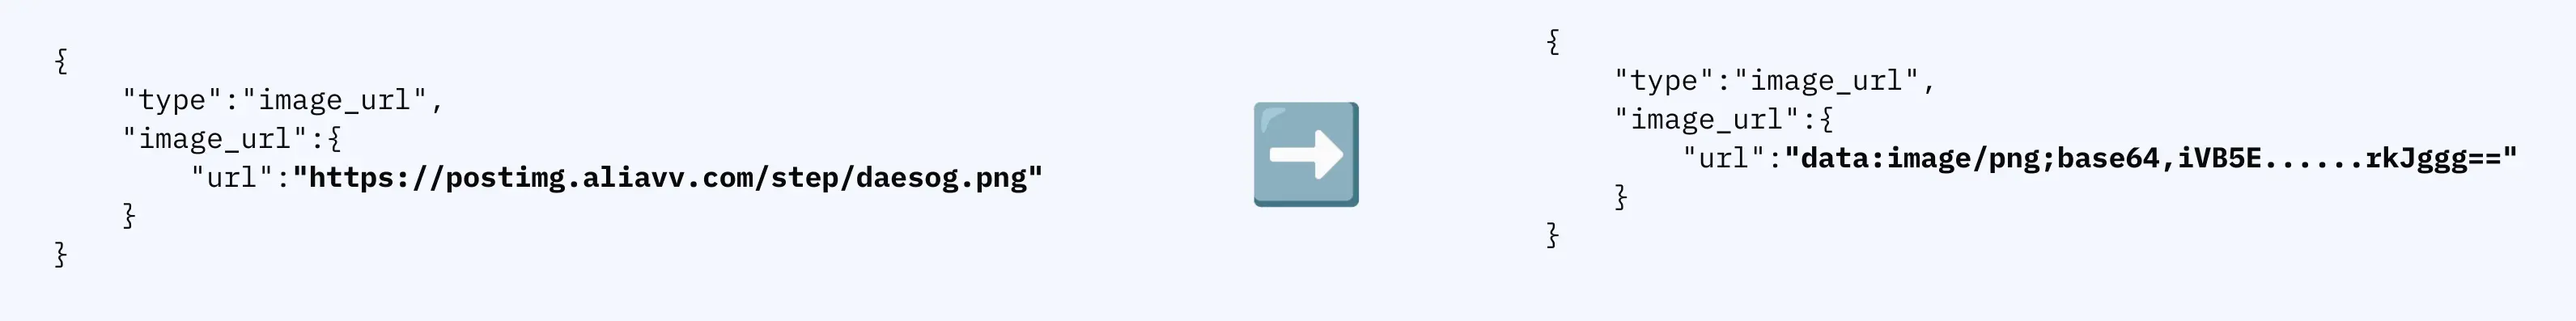

In [ ]:
# 以 Base64 输入图片
import base64
import requests


def url_to_base64(image_url: str) -> str:
    resp = requests.get(image_url, timeout=20)
    resp.raise_for_status()
    return base64.b64encode(resp.content).decode("utf-8")


b64_content = url_to_base64(TEST_IMAGE_URL)

completion_b64 = client.chat.completions.create(
    model=DEFAULT_VISION_MODEL,
    messages=[
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "使用 Base64 输入，请描述图片"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/webp;base64,{b64_content}",
                        "detail": "low",
                    },
                },
            ],
        },
    ],
)

print(completion_b64.choices[0].message.content[:500], "...")


The image shows a person wearing an elegant black outfit with a strapless design. The person has long, wavy, dark hair styled with some sections pulled back and adorned with a dark accessory. They are wearing intricate, large earrings with a floral or leaf-like design, along with a detailed silver necklace that has a prominent pendant. A silver ring is visible on one of their fingers. The background features a warm, red tone, and there is a light-colored object, possibly fabric, in the person's  ...


## 二、常见问题处理

### 2.1 图片预处理以降低延迟

In [ ]:
# 预处理：对图片缩放与压缩来获得较好的处理速度
# - step-1o 对于 detail=low 或默认，可将最长边缩放至 728px
# - step-1o 对于 detail=high，可将最长边缩放至 504 的倍数（示例用 2688）
# - step-1v 对于 detail=low 或默认，可将最长边缩放至 1280px
# - step-1v 对于 detail=high，可将最长边缩放至 2688px

# 4k图片
# https://images.pexels.com/photos/18899626/pexels-photo-18899626.jpeg
# https://images.pexels.com/photos/1146134/pexels-photo-1146134.jpeg

def resize_image(input_path: str, output_path: str, max_size: int) -> None:
    image = Image.open(input_path)
    width, height = image.size
    if width > height:
        new_width = max_size
        new_height = int((max_size / width) * height)
    else:
        new_height = max_size
        new_width = int((max_size / height) * width)
    resized_image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
    resized_image.save(output_path)


def compress_image(input_path: str, output_path: str, quality: int = 80) -> None:
    image = Image.open(input_path)
    image.save(output_path, quality=quality)

print("已定义 resize_image 与 compress_image 实用函数。")


已定义 resize_image 与 compress_image 实用函数。


In [ ]:
# 透明 PNG 适配：RGBA 转 RGB 白色背景
# https://gd-hbimg.huaban.com/7c4795bc026c359c8d17ff19d1d25b574fbb43e03088e9-ena8d7_fw1200webp
from PIL import Image

def convert_rgba_to_rgb_with_white_background(input_path: str, output_path: str) -> None:
    img = Image.open(input_path)
    if img.mode != "RGBA":
        raise ValueError("输入图片不是 RGBA 模式")
    white_background = Image.new("RGB", img.size, (255, 255, 255))
    white_background.paste(img, mask=img.split()[3])
    result = white_background.convert("RGB")
    result.save(output_path)

print("已定义 convert_rgba_to_rgb_with_white_background 实用函数。")


已定义 convert_rgba_to_rgb_with_white_background 实用函数。


## 三、其他应用

### 3.1 识别图中的主体并图片标注

In [13]:
import os
import base64
import json
import time
from typing import Dict, Any, Tuple, Optional, List

from PIL import Image, ImageDraw, ImageFont
from openai import OpenAI

STEP_API_KEY = os.environ["STEPFUN_API_KEY"]
BASE_URL= os.environ['STEPFUN_ENDPOINT']


MODEL_NAME = "step-1o-vision-32k"
RESPONSE_FORMAT_JSON = {"type": "json_object"}

# 坐标模式（用于可视化落地到像素）：强制相对坐标（0~1000）
POSITION_MODE = "relative_0_1000"

# 输入/输出
INPUT_IMAGE_PATH = "./media/03_scene.webp"
OUTPUT_IMAGE_DIR = "./media/output"     # 目录；程序会自动生成文件名
DRAW_LABEL = "crop"                         # 在图上绘制的框标签
FONT_PATHS = [
    "/System/Library/Fonts/Supplemental/Arial Unicode.ttf",
    "/System/Library/Fonts/Helvetica.ttc",
    "arial.ttf",
]
FONT_SIZE = 20

# 用户自然语言主体描述（示例：请按需修改）
SUBJECT_DESCRIPTION = "图中主要的菜品主体，完整包含并保留少量上下文边缘空间"

# 重试
MAX_RETRIES = 5
RETRY_SLEEP_SECONDS = 1

# 调试输出
VERBOSE = True
# =========================
# ===== 配置区域结束 ======
# =========================


client = OpenAI(api_key=STEP_API_KEY, base_url=BASE_URL)


def log(*args):
    if VERBOSE:
        print(*args)


# =========================
# ===== 提示词（Prompt） ===
# =========================
def build_system_prompt() -> str:
    """
    严格约束输出为单一裁剪框的 JSON：
    {
      "top_left": [x1, y1],
      "bottom_right": [x2, y2],
      "confidence": 0.95
    }
    """
    return (
        "你是一个专业的图像分析助手。你的任务是：根据用户的自然语言描述，"
        "在给定图片中定位需要裁剪的**核心主体**区域，并仅输出一个裁剪框。\n\n"
        "【输出格式（必须严格遵守）】\n"
        "只输出一个 JSON 对象，不要包含任何其他解释或文字：\n"
        "{\n"
        "  \"top_left\": [x1, y1],\n"
        "  \"bottom_right\": [x2, y2],\n"
        "  \"confidence\": 0.95\n"
        "}\n\n"
        "【坐标与边界规则】\n"
        "1) 使用**相对坐标制**：范围 0~1000 的整数；(0,0) 为左上角，x 向右、y 向下。\n"
        "2) 所有坐标必须位于图像范围内，且满足 x1 < x2、y1 < y2。\n"
        "3) 你的输出只有**一个**裁剪框；如存在多个可能主体，应将它们**合并为一个更大框**以避免重叠问题。\n"
        "4) 框需要**完整包含**用户描述的主体，同时**适度保留上下文**，避免过紧贴边缘。\n"
        "5) 置信度 confidence 取值 0.0–1.0，代表你对本次定位准确度的判断。\n\n"
        "【一致性要求】\n"
        "- 坐标字段名固定为 \"top_left\" 与 \"bottom_right\"；值均为两个整数 [x, y]，范围 0–1000。\n"
        "- 输出中不得包含额外字段、注释或解释。\n"
    )


# =========================
# ====== 工具函数 =========
# =========================
def get_image_size(image_path: str) -> Tuple[int, int]:
    with Image.open(image_path) as img:
        return img.size  # (w, h)


def image_to_base64(image_path: str) -> str:
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")


def _clamp(v: int, low: int, high: int) -> int:
    return max(low, min(v, high))


def _to_int2(pt: List[Any]) -> Optional[Tuple[int, int]]:
    if not isinstance(pt, (list, tuple)) or len(pt) != 2:
        return None
    try:
        x = int(round(float(pt[0])))
        y = int(round(float(pt[1])))
        return x, y
    except Exception:
        return None


def validate_relative_bbox(bbox: Dict[str, Any]) -> bool:
    """
    校验相对坐标 0..1000，x1<x2, y1<y2
    """
    tl = _to_int2(bbox.get("top_left"))
    br = _to_int2(bbox.get("bottom_right"))
    if tl is None or br is None:
        return False
    x1, y1 = tl
    x2, y2 = br
    if not (0 <= x1 < x2 <= 1000 and 0 <= y1 < y2 <= 1000):
        return False
    conf = bbox.get("confidence")
    try:
        conf = float(conf)
    except Exception:
        return False
    return 0.0 <= conf <= 1.0


def rel_to_abs_bbox(bbox: Dict[str, Any], img_size: Tuple[int, int]) -> Tuple[int, int, int, int]:
    """
    将相对 0..1000 的坐标转换为像素坐标（用于可视化）
    """
    w, h = img_size
    x1_rel, y1_rel = bbox["top_left"]
    x2_rel, y2_rel = bbox["bottom_right"]
    x1 = int(round(x1_rel / 1000.0 * w))
    y1 = int(round(y1_rel / 1000.0 * h))
    x2 = int(round(x2_rel / 1000.0 * w))
    y2 = int(round(y2_rel / 1000.0 * h))
    # 夹取并保证有效
    x1 = _clamp(x1, 0, w - 2)
    y1 = _clamp(y1, 0, h - 2)
    x2 = _clamp(max(x2, x1 + 1), 1, w - 1)
    y2 = _clamp(max(y2, y1 + 1), 1, h - 1)
    return x1, y1, x2, y2


def _load_font(paths: List[str], size: int) -> ImageFont.FreeTypeFont:
    for p in paths:
        try:
            return ImageFont.truetype(p, size=size)
        except Exception:
            continue
    return ImageFont.load_default()


def annotate_image(image_path: str, bbox_abs: Tuple[int, int, int, int], output_path: str, label: str = "crop") -> None:
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with Image.open(image_path) as img:
        if img.mode != "RGBA":
            img = img.convert("RGBA")

        draw = ImageDraw.Draw(img)
        font = _load_font(FONT_PATHS, FONT_SIZE)

        x1, y1, x2, y2 = bbox_abs
        draw.rectangle([x1, y1, x2, y2], outline=(255, 0, 0, 255), width=2)

        # 居中标签
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
        l, t, r, b = draw.textbbox((0, 0), label, font=font)
        tw, th = r - l, b - t
        pad = 6
        rect = [cx - tw // 2 - pad, cy - th // 2 - pad, cx + tw // 2 + pad, cy + th // 2 + pad]
        W, H = img.size
        # 夹取
        dx = -min(0, rect[0]) + min(0, W - rect[2])
        dy = -min(0, rect[1]) + min(0, H - rect[3])
        rect = [rect[0] + dx, rect[1] + dy, rect[2] + dx, rect[3] + dy]

        draw.rectangle(rect, fill=(0, 0, 0, 140))
        draw.text((rect[0] + pad, rect[1] + pad), label, fill=(255, 255, 255, 255), font=font)

        ext = os.path.splitext(output_path)[1].lower()
        if ext in [".jpg", ".jpeg"]:
            background = Image.new("RGB", img.size, (255, 255, 255))
            background.paste(img, mask=img.split()[3])
            background.save(output_path, quality=95)
        else:
            img.save(output_path)

    log(f"标注后的图像已保存至 {output_path}")


# =========================
# ====== 推理请求 =========
# =========================
def call_model(image_b64: str, description: str) -> Optional[Dict[str, Any]]:
    sys_prompt = build_system_prompt()
    log("系统提示内容:\n\n", sys_prompt)

    messages = [
        {"role": "system", "content": sys_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": f"主体描述：{description}"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpg;base64,{image_b64}",
                        "detail": "high",
                    },
                },
                {"type": "text", "text": "请基于以上描述与图像，返回唯一的裁剪框 JSON。"},
            ],
        },
    ]

    try:
        response = client.chat.completions.create(
            messages=messages,
            model=MODEL_NAME,
            response_format=RESPONSE_FORMAT_JSON,
        )
    except Exception as e:
        log(f"API请求失败: {e}")
        return None

    # 打印完整响应（可按需注释）
    log(response)

    try:
        content = response.choices[0].message.content.strip()
        log("原始返回：", content)
        data = json.loads(content)
        return data
    except Exception as e:
        log("解析JSON失败，请检查API返回内容。报错：", e)
        return None


# =========================
# ========= 主流程 =========
# =========================
def main():
    img_w, img_h = get_image_size(INPUT_IMAGE_PATH)
    log(f"图像大小: {(img_w, img_h)}")

    image_b64 = image_to_base64(INPUT_IMAGE_PATH)

    attempt = 0
    while attempt < MAX_RETRIES:
        try:
            result = call_model(image_b64, SUBJECT_DESCRIPTION)
            if not result:
                log("未能获取有效的分析结果。")
                attempt += 1
                time.sleep(RETRY_SLEEP_SECONDS)
                continue

            # 校验相对坐标与结构
            if not validate_relative_bbox(result):
                log("返回的坐标不符合 0..1000 或结构不正确，重试...")
                attempt += 1
                time.sleep(RETRY_SLEEP_SECONDS)
                continue

            # 相对 -> 像素（仅用于可视化）
            x1, y1, x2, y2 = rel_to_abs_bbox(result, (img_w, img_h))

            # 生成输出文件名
            os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
            base_name = os.path.splitext(os.path.basename(INPUT_IMAGE_PATH))[0]
            timestamp = time.strftime("%Y%m%d_%H%M%S")
            file_name = f"{base_name}_{MODEL_NAME}_{timestamp}.png"
            output_path = os.path.join(OUTPUT_IMAGE_DIR, file_name)

            annotate_image(INPUT_IMAGE_PATH, (x1, y1, x2, y2), output_path, DRAW_LABEL)

            # 控制台也打印一次标准 JSON，便于直接消费
            # 注意：此处打印的就是“相对坐标 0..1000”的原始返回
            print(json.dumps({
                "top_left": [int(result["top_left"][0]), int(result["top_left"][1])],
                "bottom_right": [int(result["bottom_right"][0]), int(result["bottom_right"][1])],
                "confidence": float(result["confidence"])
            }, ensure_ascii=False))
            return

        except Exception as e:
            log(f"发生错误: {e}")
            attempt += 1
            time.sleep(RETRY_SLEEP_SECONDS)

    log("达到最大重试次数，操作失败。")


if __name__ == "__main__":
    main()

图像大小: (720, 967)
系统提示内容:

 你是一个专业的图像分析助手。你的任务是：根据用户的自然语言描述，在给定图片中定位需要裁剪的**核心主体**区域，并仅输出一个裁剪框。

【输出格式（必须严格遵守）】
只输出一个 JSON 对象，不要包含任何其他解释或文字：
{
  "top_left": [x1, y1],
  "bottom_right": [x2, y2],
  "confidence": 0.95
}

【坐标与边界规则】
1) 使用**相对坐标制**：范围 0~1000 的整数；(0,0) 为左上角，x 向右、y 向下。
2) 所有坐标必须位于图像范围内，且满足 x1 < x2、y1 < y2。
3) 你的输出只有**一个**裁剪框；如存在多个可能主体，应将它们**合并为一个更大框**以避免重叠问题。
4) 框需要**完整包含**用户描述的主体，同时**适度保留上下文**，避免过紧贴边缘。
5) 置信度 confidence 取值 0.0–1.0，代表你对本次定位准确度的判断。

【一致性要求】
- 坐标字段名固定为 "top_left" 与 "bottom_right"；值均为两个整数 [x, y]，范围 0–1000。
- 输出中不得包含额外字段、注释或解释。

ChatCompletion(id='db8e4df3c251feb0b08458fc8ee5525f.1b467119fc082c9030a39c7eb2be0965', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{"top_left": [240, 445], "bottom_right": [485, 840], "confidence": 0.95}', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=None))], created=1757672021, model='step-1o-vision-32k', object='chat.completion', servi